In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path
import os

from sklearn.metrics import classification_report
import tensorflow.keras.backend as K

from tensorflow.keras import layers

In [ ]:
# Config 
INPUT_DIR = Path("/kaggle/working/output_wav2vec_custom_augmented")
OUTPUT_DIR = Path("./output_improv_cnfmr_bs2_class_tpu")
OUTPUT_DIR.mkdir(exist_ok=True)

MAX_SEQ_LEN = 150
EMBEDDING_DIM = 768
LABEL_COLS = ['Prolongation', 'Block', 'SoundRep', 'WordRep', 'Interjection']
NUM_CLASSES = len(LABEL_COLS)

BATCH_SIZE_PER_REPLICA = 32
EPOCHS = 400
LEARNING_RATE = 1e-5
THRESHOLD = 0.5

TRAIN_DATA_PATH = INPUT_DIR / "train_data.npz"
VAL_DATA_PATH = INPUT_DIR / "val_data.npz"
TEST_DATA_PATH = INPUT_DIR / "test_data.npz"
OUTPUT_DIR = Path("./")
BEST_MODEL_PATH = OUTPUT_DIR / "best_improv_cnfmr_bs2_model.keras"

In [ ]:
print("--- Initializing TPU Strategy ---")

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu='local')
    # tf.config.experimental_connect_to_cluster(tpu)
    # tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    
    print('TPU successfully initialized. Found TPU: ', tpu.master())
    print("Number of replicas:", strategy.num_replicas_in_sync)

except Exception as e:
    print(f"TPU initialization failed, this is the error: {e}")
    print("Falling back to default strategy (CPU/GPU).")
    strategy = tf.distribute.get_strategy()
    BATCH_SIZE = BATCH_SIZE_PER_REPLICA


--- Initializing TPU Strategy ---
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1753442756.489284    1469 service.cc:148] XLA service 0x5c7008572b70 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753442756.489357    1469 service.cc:156]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1753442756.489364    1469 service.cc:156]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1753442756.489367    1469 service.cc:156]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1753442756.489370    1469 service.cc:156]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1753442756.489373    1469 service.cc:156]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1753442756.489376    1469 service.cc:156]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1753442756.489378    1469 service.cc:156]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1753442756.489381    1469 service.cc:156]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

In [ ]:

BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
print(f"Global batch size set to: {BATCH_SIZE}")

Global batch size set to: 256


In [ ]:
print("\nLoading all compressed features")

train_data = np.load(TRAIN_DATA_PATH)
val_data = np.load(VAL_DATA_PATH)
test_data = np.load(TEST_DATA_PATH)

# Access the arrays by the keys we used when saving ('x' and 'y')
X_train, y_train = train_data['x'], train_data['y']
X_val, y_val = val_data['x'], val_data['y']
X_test, y_test = test_data['x'], test_data['y']


print("All compressed data loaded successfully.")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")


Loading all compressed features
All compressed data loaded successfully.
X_train shape: (33945, 150, 768)
y_train shape: (33945, 6)


In [ ]:
# Remove the last column ('NoStutter') from the labels
y_train = y_train[:, :-1]
y_val = y_val[:, :-1]
y_test = y_test[:, :-1]

# Filter out samples that now have NO labels
train_indices = np.where(y_train.sum(axis=1) > 0)[0]
val_indices = np.where(y_val.sum(axis=1) > 0)[0]
test_indices = np.where(y_test.sum(axis=1) > 0)[0]

X_train, y_train = X_train[train_indices], y_train[train_indices]
X_val, y_val = X_val[val_indices], y_val[val_indices]
X_test, y_test = X_test[test_indices], y_test[test_indices]

print("Data loaded and modified successfully.")
print(f"New X_train shape: {X_train.shape}")

Data loaded and modified successfully.
New X_train shape: (29783, 150, 768)


In [ ]:
print("\n Verifying final training set distribution after augmentation")

final_train_labels_df = pd.DataFrame(y_train, columns=LABEL_COLS)

print("Final distribution of labels in the training set (including augmented samples):")
print(final_train_labels_df.sum().sort_values(ascending=False))



 Verifying final training set distribution after augmentation
Final distribution of labels in the training set (including augmented samples):
Block           10848
Interjection    10824
Prolongation    10800
SoundRep        10576
WordRep         10569
dtype: int64


In [ ]:
print("\nBuilding tf.data pipeline")

def prepare_dataset(X, y, shuffle=False, drop_remainder = False):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    ds = ds.cache()
    if shuffle:
        ds = ds.shuffle(buffer_size=2048)
    ds = ds.batch(BATCH_SIZE, drop_remainder=drop_remainder)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

train_dataset = prepare_dataset(X_train, y_train, shuffle=True, drop_remainder=True)
val_dataset = prepare_dataset(X_val, y_val, shuffle=False, drop_remainder=True)
test_dataset = prepare_dataset(X_test, y_test, shuffle=False, drop_remainder=True)
print("Datasets created successfully.")



Building tf.data pipeline
Datasets created successfully.


In [ ]:
with strategy.scope():
    print("\nBuilding Conformer Model")

    # Conformer Block
    def conformer_block(x, num_heads=4, ff_dim=128, dropout=0.1):
        # Convolution Module
        x_conv = layers.LayerNormalization()(x)
        x_conv = layers.Conv1D(filters=EMBEDDING_DIM * 2, kernel_size=1, activation="relu")(x_conv)
        x_conv = layers.DepthwiseConv1D(kernel_size=3, padding="same")(x_conv)
        x_conv = layers.BatchNormalization()(x_conv)
        x_conv = layers.Activation("swish")(x_conv)
        x_conv = layers.Conv1D(filters=EMBEDDING_DIM, kernel_size=1)(x_conv)
        x_conv = layers.Dropout(dropout)(x_conv)
        x = x + x_conv # Residual connection

        # Attention Module
        x_attn = layers.LayerNormalization()(x)
        x_attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=EMBEDDING_DIM // num_heads)(x_attn, x_attn)
        x_attn = layers.Dropout(dropout)(x_attn)
        x = x + x_attn # Residual connection

        # Feed Forward Module
        x_ff = layers.LayerNormalization()(x)
        x_ff = layers.Dense(ff_dim, activation="swish")(x_ff)
        x_ff = layers.Dropout(dropout)(x_ff)
        x_ff = layers.Dense(EMBEDDING_DIM)(x_ff)
        x = x + x_ff # Residual connection

        return x

    def build_conformer_classifier(input_shape, num_classes):
        inputs = layers.Input(shape=input_shape)
        x = inputs

        # Applies Conformer blocks
        x = conformer_block(x, num_heads=4, ff_dim=1028)
        x = conformer_block(x, num_heads=4, ff_dim=1028)

        # Pools the sequence to a single vector
        x = layers.GlobalAveragePooling1D()(x)

        # Classifier head
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dropout(0.5)(x)
        outputs = layers.Dense(num_classes, activation='sigmoid')(x)

        model = tf.keras.Model(inputs=inputs, outputs=outputs)

        optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, clipnorm=1.0)
        
        model.compile(
            optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.AUC(name='auc', multi_label=True)]
        )
        return model

    model = build_conformer_classifier(input_shape=(MAX_SEQ_LEN, EMBEDDING_DIM), num_classes=NUM_CLASSES)

model.summary()

checkpoint = tf.keras.callbacks.ModelCheckpoint(BEST_MODEL_PATH, monitor='val_auc', mode='max', save_best_only=True, verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=10, restore_best_weights=True)

print(f"LEARNING RATE: {LEARNING_RATE}")
print(f"BATCH SIZE: {BATCH_SIZE}")



Building Conformer Model


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 150, 768)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 150, 768)  │      1,536 │ input_layer_1[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 150, 1536) │  1,181,184 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv1d_2  │ (None, 150, 1536) │      6,144 │ conv1d_4[0][0]    │
│ (DepthwiseConv1D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 150, 1536) │      6,144 │ depthwise_conv1d… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 150, 1536) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 150, 768)  │  1,180,416 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 150, 768)  │          0 │ conv1d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 150, 768)  │          0 │ input_layer_1[0]… │
│                     │                   │            │ dropout_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 150, 768)  │      1,536 │ add_6[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 150, 768)  │  2,362,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 150, 768)  │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 150, 768)  │          0 │ add_6[0][0],      │
│                     │                   │            │ dropout_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 150, 768)  │      1,536 │ add_7[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 150, 1028) │    790,532 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 150, 1028) │          0 │ dense_6[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 150, 768)  │    790,272 │ dropout_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 150, 768)  │          0 │ add_7[0][0],      │
│                     │                   │            │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 12,742,413 (48.61 MB)

 Trainable params: 12,736,269 (48.59 MB)

 Non-trainable params: 6,144 (24.00 KB)

LEARNING RATE: 1e-05
BATCH SIZE: 256


In [17]:
print("\nStarting Training on TPU")
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[checkpoint, early_stopping]
)


Starting Training on TPU
Epoch 1/400


I0000 00:00:1753444553.094556    1469 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:1170026858346159596
I0000 00:00:1753444554.425648    2277 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(13664350401286847047), session_name()
I0000 00:00:1753444571.707280    2277 tpu_compile_op_common.cc:245] Compilation of 13664350401286847047 with session name  took 17.281596618s and succeeded
I0000 00:00:1753444571.756566    2277 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(13664350401286847047), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_1170026858346159596", property.function_library_fingerprint = 3134239925791079039, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap()

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.2524 - auc: 0.5619 - loss: 0.6928 - precision: 0.4398 - recall: 0.3115

I0000 00:00:1753444593.178446    1469 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:1557074433012212081
I0000 00:00:1753444593.441577    2275 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(18391004071088102247), session_name()
I0000 00:00:1753444595.249070    2275 tpu_compile_op_common.cc:245] Compilation of 18391004071088102247 with session name  took 1.807442215s and succeeded
I0000 00:00:1753444595.254754    2275 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(18391004071088102247), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_1557074433012212081", property.function_library_fingerprint = 12226089480476022475, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap()


Epoch 1: val_auc improved from -inf to 0.64482, saving model to best_improv_cnfmr_bs2_model.keras
116/116 ━━━━━━━━━━━━━━━━━━━━ 62s 225ms/step - accuracy: 0.2525 - auc: 0.5623 - loss: 0.6924 - precision: 0.4402 - recall: 0.3112 - val_accuracy: 0.3438 - val_auc: 0.6448 - val_loss: 0.6423 - val_precision: 0.6147 - val_recall: 0.0664
Epoch 2/400
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.2799 - auc: 0.6534 - loss: 0.6226 - precision: 0.5753 - recall: 0.3044
Epoch 2: val_auc improved from 0.64482 to 0.66810, saving model to best_improv_cnfmr_bs2_model.keras
116/116 ━━━━━━━━━━━━━━━━━━━━ 35s 191ms/step - accuracy: 0.2800 - auc: 0.6534 - loss: 0.6226 - precision: 0.5752 - recall: 0.3045 - val_accuracy: 0.3340 - val_auc: 0.6681 - val_loss: 0.6391 - val_precision: 0.6526 - val_recall: 0.1992
Epoch 3/400
115/116 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.3225 - auc: 0.6774 - loss: 0.6021 - precision: 0.5878 - recall: 0.3512
Epoch 3: val_auc improved from 0.66810 to 0.68713, sav


--- Evaluating Model on the Test Set ---


I0000 00:00:1753443824.763122    1469 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:14010014713553170828
E0000 00:00:1753443824.810063    1469 meta_optimizer.cc:966] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node functional_1/batch_normalization_1/Cast/ReadVariableOp.
I0000 00:00:1753443824.924073    2271 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(16515783266257873755), session_name()
I0000 00:00:1753443826.303823    2271 tpu_compile_op_common.cc:245] Compilation of 16515783266257873755 with session name  took 1.379700387s and succeeded
I0000 00:00:1753443826.308201    2271 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(16515783266257873755), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_14010014713553170828", property.function_library_fingerprint = 9996733183210744485, property.mlir_modu

54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step

--- Classification Report (5 Stuttering Classes) ---
              precision    recall  f1-score   support

Prolongation       0.63      0.56      0.59      2608
       Block       0.60      0.51      0.55      3474
    SoundRep       0.60      0.49      0.54      1877
     WordRep       0.59      0.36      0.45      1735
Interjection       0.89      0.60      0.72      3333

   micro avg       0.67      0.52      0.59     13027
   macro avg       0.66      0.50      0.57     13027
weighted avg       0.68      0.52      0.59     13027
 samples avg       0.63      0.54      0.55     13027


--- Generating plots for model training history... ---


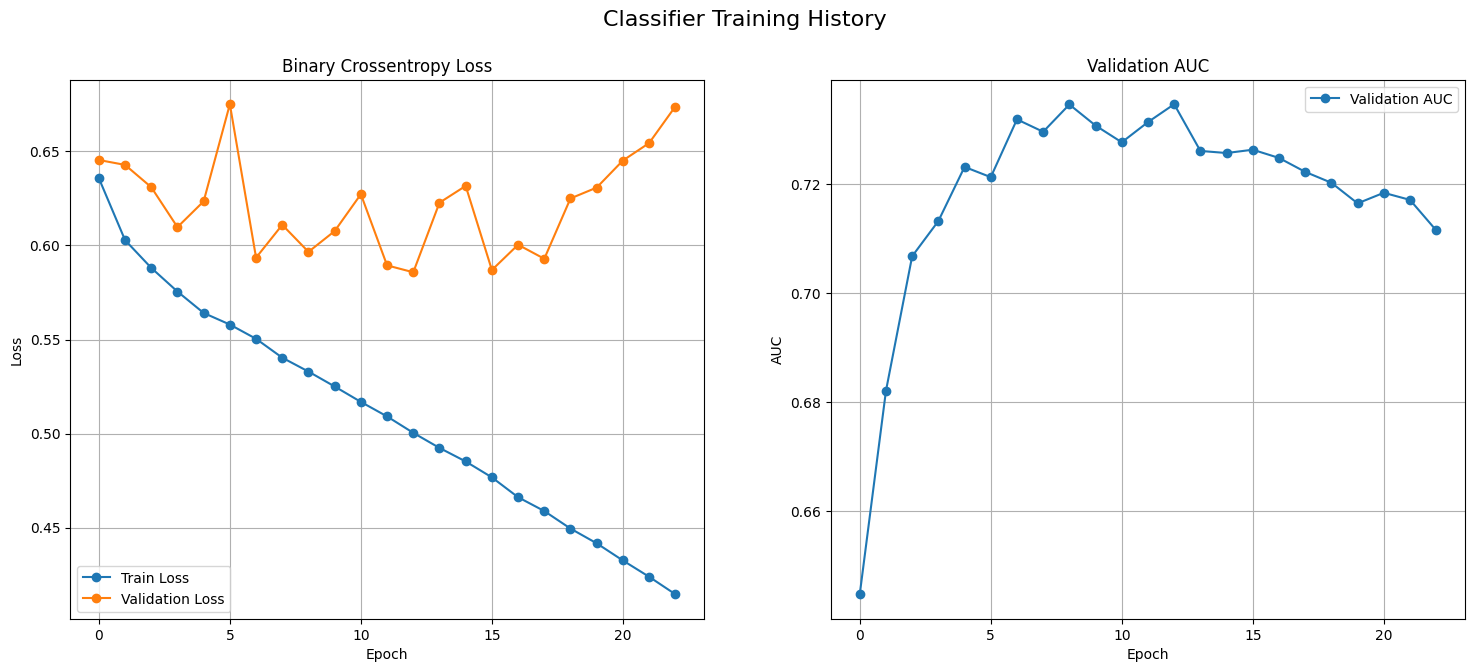

In [ ]:

from sklearn.metrics import multilabel_confusion_matrix, precision_recall_curve, average_precision_score
import itertools

print("\n--- Evaluating Model on the Test Set ---")
y_pred_probs = model.predict(test_dataset)
y_pred_binary = (y_pred_probs > THRESHOLD).astype(int)

num_predictions = len(y_pred_binary)
y_test_eval = y_test[:num_predictions]

print("\n--- Classification Report (5 Stuttering Classes) ---")
report = classification_report(y_test_eval, y_pred_binary, target_names=LABEL_COLS, zero_division=0)
print(report)
with open(OUTPUT_DIR / "classification_report.txt", "w") as f:
    f.write(report)

print("\n--- Generating plots for model training history... ---")
history_dict = history.history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Classifier Training History', fontsize=16)
ax1.plot(history_dict['loss'], 'o-', label='Train Loss')
ax1.plot(history_dict['val_loss'], 'o-', label='Validation Loss')
ax1.set_title('Binary Crossentropy Loss'); ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.legend(); ax1.grid(True)
ax2.plot(history_dict['val_auc'], 'o-', label='Validation AUC')
ax2.set_title('Validation AUC'); ax2.set_xlabel('Epoch'); ax2.set_ylabel('AUC'); ax2.legend(); ax2.grid(True)
plt.savefig(OUTPUT_DIR / "training_history.png")
plt.show()


--- Evaluating Model on the Test Set ---


I0000 00:00:1753445617.974803    1469 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:11219710530059542960
E0000 00:00:1753445618.021181    1469 meta_optimizer.cc:966] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node functional_1_1/batch_normalization_2_1/Cast/ReadVariableOp.
I0000 00:00:1753445618.154329    2278 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(14212319588356899812), session_name()
I0000 00:00:1753445619.650583    2278 tpu_compile_op_common.cc:245] Compilation of 14212319588356899812 with session name  took 1.496184217s and succeeded
I0000 00:00:1753445619.654411    2278 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(14212319588356899812), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_11219710530059542960", property.function_library_fingerprint = 10577014276559536661, property.mlir

27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 160ms/step

--- Classification Report (5 Stuttering Classes) ---
              precision    recall  f1-score   support

Prolongation       0.66      0.50      0.57      2608
       Block       0.61      0.51      0.55      3474
    SoundRep       0.55      0.57      0.56      1877
     WordRep       0.53      0.50      0.51      1735
Interjection       0.89      0.61      0.72      3333

   micro avg       0.66      0.54      0.59     13027
   macro avg       0.65      0.54      0.58     13027
weighted avg       0.67      0.54      0.60     13027
 samples avg       0.63      0.56      0.56     13027


--- Generating plots for model training history... ---


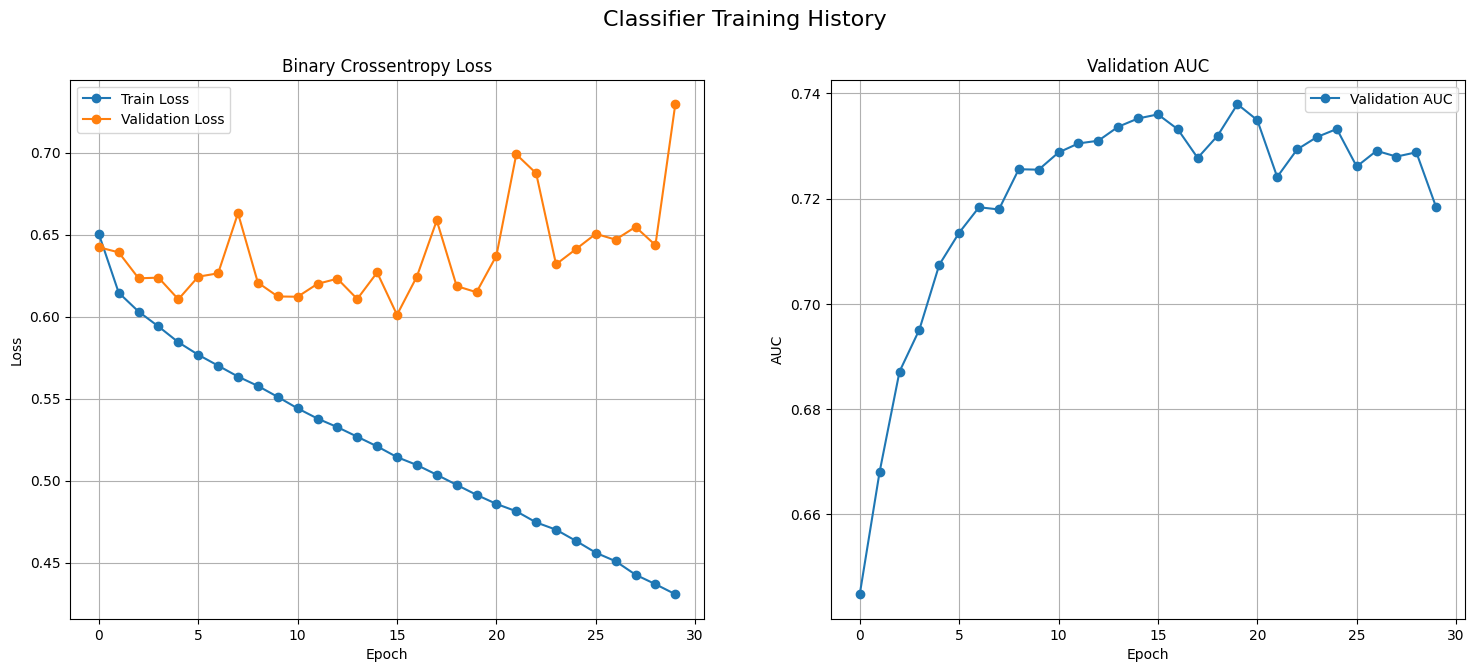

In [ ]:
# BATCH SIZE CHANGE: 128->256

from sklearn.metrics import multilabel_confusion_matrix, precision_recall_curve, average_precision_score
import itertools

print("\n--- Evaluating Model on the Test Set ---")
y_pred_probs = model.predict(test_dataset)
y_pred_binary = (y_pred_probs > THRESHOLD).astype(int)

num_predictions = len(y_pred_binary)
y_test_eval = y_test[:num_predictions]

print("\n--- Classification Report (5 Stuttering Classes) ---")
report = classification_report(y_test_eval, y_pred_binary, target_names=LABEL_COLS, zero_division=0)
print(report)
with open(OUTPUT_DIR / "classification_report.txt", "w") as f:
    f.write(report)

print("\n--- Generating plots for model training history... ---")
history_dict = history.history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Classifier Training History', fontsize=16)
ax1.plot(history_dict['loss'], 'o-', label='Train Loss')
ax1.plot(history_dict['val_loss'], 'o-', label='Validation Loss')
ax1.set_title('Binary Crossentropy Loss'); ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.legend(); ax1.grid(True)
ax2.plot(history_dict['val_auc'], 'o-', label='Validation AUC')
ax2.set_title('Validation AUC'); ax2.set_xlabel('Epoch'); ax2.set_ylabel('AUC'); ax2.legend(); ax2.grid(True)
plt.savefig(OUTPUT_DIR / "training_history.png")
plt.show()

Multiple Strategies tried to improve the scissor graph , which lead to better training graphs but slight decrease in f1. 
(REFER BATCH RUN NOTEBOOK)